In [6]:
from functions import *
import math
import numpy as np
import torch as t
from torch import tensor
import scipy.constants as con
import matplotlib.pyplot as plt
import torch.linalg as ln
import scipy
import scipy.stats as stats
from mpl_toolkits import mplot3d
import variables as vr
from classes import *
from random import random



"""

The following code initializes the model with rubidium, certain transitions, some laserbeams, and a collision rule.

"""


#Rubidium Data
rubidium=species(
    con.atomic_mass*86.909180520,
    #defining energy levels should be expandable, need to dynamically assign energy levels (in terms of transitions and/or in terms of levels?)
    {
        "S12F1":0,
        "S12F2":4.5283e-24,
        "P12F0":2.54593588e-19,
        "P12F1":2.54593636e-19,
        "P12F2":2.545937398e-19,
        "P12F3":2.54593917e-19
    },
    87,
    1.5
)
    
    

#defining the transitions we care about (NEEDS to be declared before generating particles,
# transitions cared about tells which levels to generate for the particles)
#The branching ratios/ transition strenghts are currently added manually, in future these may be calculated procedurally.
Coolingbranrat=Tensor([
        [15,5,1,0,0,0,0],
        [0,10,8,3,0,0,0],
        [0,0,6,9,6,0,0],
        [0,0,0,3,8,10,0],
        [0,0,0,0,1,5,15]
    ]).to(vr.def_device)/15

D2repumpbranrat=Tensor([
        [6,3,1,0,0,],
        [0,3,4,3,0],
        [0,0,1,3,6]
    ]).to(vr.def_device)/12

D2offsetbranrat=Tensor([
        [4,2,0,0,0,],
        [2,1,3,0,0,],
        [0,3,0,3,0,],
        [0,0,3,1,2],
        [0,0,0,2,4]
    ]).to(vr.def_device)/12


rubidium.D2cooling=Transition(38.11e6,"S12F2","P12F3",rubidium,Coolingbranrat)
rubidium.D2repump=Transition(38.11e6,"S12F1","P12F2",rubidium,D2repumpbranrat)
rubidium.D2offres=Transition(38.11e6,"S12F2","P12F2",rubidium,D2offsetbranrat)
rubidium.createstructure()


#defining cooling lasers
Int=100
Cooling1=laserbeam([1,0,0],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[1,0,0])
Cooling2=laserbeam([-1,0,0],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[1,0,0])
Cooling3=laserbeam([0,1,0],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[0,0,1])
Cooling4=laserbeam([0,-1,0],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[0,0,1])
Cooling5=laserbeam([0,0,1],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[0,0,1])
Cooling6=laserbeam([0,0,-1],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[0,0,1])
Laserbeams=[Cooling1,Cooling2,Cooling3,Cooling4,Cooling5,Cooling6]

def AHh(x,A=0.0015):
    return (t.matmul(x,t.diag(tensor([A,A,-2*A],device=x.device,dtype=x.dtype))))


Env=Environment(3e-5 ,Laserbeams,300,B=AHh)



#need to sort out how to assign `rules` modularly, for now the following rule will create a pyramid which will do.
def rule(x,def_device=vr.def_device):
    x,y,z=x[:,0],x[:,1],x[:,2]
    A=t.max(abs(x),abs(y))-z-0.1*t.ones(x.shape[0],device=def_device)
    A+=t.abs(A)
    A=t.ceil(A)
    A=(A==t.zeros(A.shape[0],device=A.device))
    #if given a tensor of positions, will return a tensor of bools for whether the rule is followed or not.
    return A

prub=particles(rubidium)




In [2]:


#code demonstrating the retrieval of intensity from a laserbeam for given particle positions
positions=(1-2*t.zeros((10000,3)).uniform_())*0.1
I=Cooling1.intensity(positions)
print(t.max(I))


tensor(99.3968)


In [3]:
AHh(torch.ones((200,3)),1).shape

torch.Size([200, 3])

torch.Size([615250, 3])
tensor([[ -96.8279,  -37.3084,  206.2973],
        [-154.2388,  151.7899,   66.7682],
        [ -33.1803, -129.7099,  -11.5145],
        ...,
        [-161.4136, -160.1108,  218.9973],
        [-203.1516, -303.7613,  115.5874],
        [  44.0428,   92.5452,  486.0934]], dtype=torch.float64)


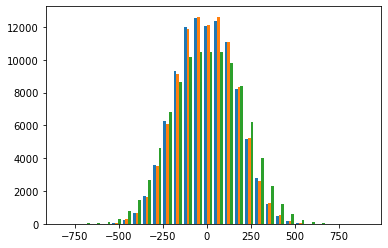

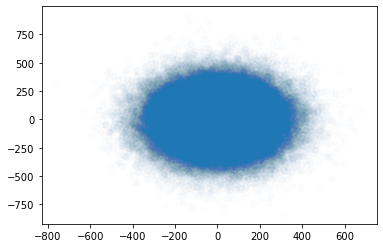

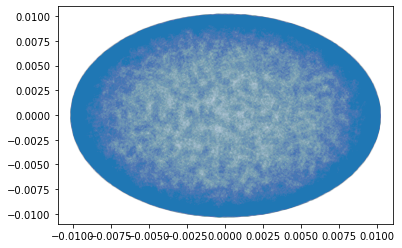

In [4]:
prub.createbyT(100)
prub.timestepadd(dt=0.0000001)
print(prub.x.shape)

prub.createbyT(100000)
print(prub.v)
plt.hist(prub.v.T,30)
plt.show()
plt.scatter(prub.v[:,1],prub.v[:,2],alpha=0.01)
plt.show()
plt.scatter(prub.x[:,1],prub.x[:,2],alpha=0.01)

#demonstrator code, showing the capacity of the particles class to generate new particles and their velocities/positions.


In [225]:
def forward(particles,Environment,dt=0.0000001):
    for p in particles:
        R=t.zeros((p.N,len(Environment.laserbeams),p.species.lvlsize,p.species.lvlsize),device=vr.def_device)
        for i in Environment.laserbeams:
            print(i.pol)
            

forward([prub],Env)

tensor([0, 0, 1])
tensor([0, 0, 1])
tensor([0, 0, 1])
tensor([0, 0, 1])
tensor([1, 0, 0])
tensor([1, 0, 0])


torch.Size([1, 6, 3, 1])


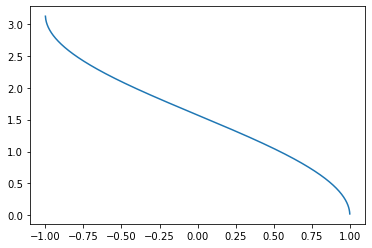

In [75]:
X=t.linspace(-2*pi,2*pi,10000)
Y=t.arccos(X)

plt.plot(X,Y)

In [ ]:
#working on rotation matrix for all beams and particles
def eploc(x,Environment,def_device=vr.def_device):
    dirs=t.zeros((len(Environment.laserbeams),3))
    eps=t.zeros((len(Environment.laserbeams),3))
    for i in range(len(Environment.laserbeams)): 
        dirs[i]=Environment.laserbeams[i].dir
        eps[i]=Environment.laserbeams[i].pol
    Bloc=Environment.B(x)
    nBloc=t.div(Bloc,ln.norm(Bloc,dim=1).unsqueeze(1))
    v=t.cross(nBloc.unsqueeze(1).repeat(1,len(Environment.laserbeams),1),dirs.unsqueeze(0).repeat(nBloc.shape[0],1,1))
    
    #the following is to deal with the edge case that the direction of one of the laserbeams is paralel to that of one of the B fields.
    k=ln.norm(v,dim=2)
    k=(k==t.zeros(k.shape,device=k.device,dtype=k.dtype)).to(k.dtype)
    k=k.unsqueeze(-1).repeat(1,1,3)*0.000001
    v=t.cross(nBloc.unsqueeze(1).repeat(1,len(Environment.laserbeams),1)+k,dirs.unsqueeze(0).repeat(nBloc.shape[0],1,1))
    print(k)





    v=t.div(v,ln.norm(v,dim=2).unsqueeze(2))
    s=ln.norm(v,dim=2).unsqueeze(-1).unsqueeze(-1).repeat(1,1,3,3)
    c=(t.ones((Bloc.shape[0],dirs.shape[0]),device=def_device)-t.sum(t.mul(nBloc.unsqueeze(1).repeat(1,dirs.shape[0],1),dirs.unsqueeze(0).repeat(Bloc.shape[0],1,1)),dim=2)).unsqueeze(-1).unsqueeze(-1).repeat(1,1,3,3)

    skew=t.zeros(v.shape,device=v.device).unsqueeze(-1).repeat(1,1,1,3)
    skew[:,:,1,0],skew[:,:,0,1]=v[:,:,2],-v[:,:,2]
    skew[:,:,2,0],skew[:,:,0,2]=-v[:,:,1],v[:,:,1]
    skew[:,:,2,1],skew[:,:,1,2]=v[:,:,0],-v[:,:,0]
    I=t.diag(t.ones(3)).unsqueeze(0).unsqueeze(0).repeat(skew.shape[0],skew.shape[1],1,1)+skew

    #O=t.matmul(skew,skew)
    #print(skew.shape)
    R=I+t.mul(s,skew)+t.mul(c,t.matmul(skew,skew))
    I,s,c,skew,v=None,None,None,None,None
    '''
    epr=t.matmul(tensor([[-1/sqrt(2),0,1/sqrt(2)],[0,0,0],[0,1,0]]).to(vr.def_device).unsqueeze(0).repeat(eps.shape[0],1,1),eps.unsqueeze(2)).unsqueeze(0).repeat(nBloc.shape[0],1,1,1)
    epc=t.matmul(tensor([[0,0,0],[1/sqrt(2),0,1/sqrt(2)],[0,0,0]]).to(vr.def_device).unsqueeze(0).repeat(eps.shape[0],1,1),eps.unsqueeze(2)).unsqueeze(0).repeat(nBloc.shape[0],1,1,1)
    epr=t.matmul(R,epr)
    epc=t.matmul(R,epc)

    epr1=torch.matmul(Tensor([[-1/sqrt(2),0,0],[0,0,1],[1/sqrt(2),0,0]]).to(vr.def_device).unsqueeze(0).unsqueeze(1).repeat(epr.shape[0],epr.shape[1],1,1),epr)
    epr2=torch.matmul(Tensor([[0,1/sqrt(2),0],[0,0,0],[0,1/sqrt(2),0]]).to(vr.def_device).unsqueeze(0).unsqueeze(1).repeat(epr.shape[0],epr.shape[1],1,1),epc)
    
    epc1=torch.matmul(Tensor([[-1/sqrt(2),0,0],[0,0,1],[1/sqrt(2),0,0]]).to(vr.def_device).unsqueeze(0).unsqueeze(1).repeat(epr.shape[0],epr.shape[1],1,1),epc)
    epc2=torch.matmul(Tensor([[0,-1/sqrt(2),0],[0,0,0],[0,-1/sqrt(2),0]]).to(vr.def_device).unsqueeze(0).unsqueeze(1).repeat(epr.shape[0],epr.shape[1],1,1),epr)
    
    epr=epr1+epr2
    epc=epc1+epc2
    eps=torch.norm(torch.cat((epr.unsqueeze(0),epc.unsqueeze(0)),0),dim=0)
    '''
    return R
print(eploc(tens.x.unsqueeze(0),Env)[0])
#O=O*(1-t.mul(nBloc.unsqueeze(1).repeat(1,len(Env.laserbeams),1),dirs.unsqueeze(0).repeat(nBloc.shape[0],1,1)))

tensor([[[1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]])
tensor([[[ 1.0000e+00,  1.4142e+00,  1.4142e+00],
         [-1.4142e+00,  1.0000e+00,  0.0000e+00],
         [-1.4142e+00,  0.0000e+00,  1.0000e+00]],

        [[-1.0000e+00, -1.4142e+00, -1.4142e+00],
         [ 1.4142e+00,  5.9605e-08, -1.0000e+00],
         [ 1.4142e+00, -1.0000e+00,  5.9605e-08]],

        [[ 0.0000e+00, -2.0000e+00,  0.0000e+00],
         [ 2.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 0.0000e+00,  2.0000e+00,  0.0000e+00],
         [-2.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00, -2.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
        

In [47]:
k=tens.x.unsqueeze(0).repeat(1000000000,1)